In [5]:
import os
import csv
import re
import pickle
import random
import math
import dicom
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from skimage import transform
from sklearn.externals import joblib
from scipy import ndimage
from matplotlib import path

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
with open('../../data_supp/sunnybrook_study_files.pkl', 'rb') as f:
    sunnybrook_study_files = pickle.load(f)
with open('../../data_supp/sunnybrook_contour_files.pkl', 'rb') as f:
    sunnybrook_contour_files = pickle.load(f)
with open('../../data_supp/sunnybrook_series_contour_match.pkl', 'rb') as f:
    sunnybrook_series_contour_match = pickle.load(f)

with open('../../data_supp/filepaths_train.pkl', 'rb') as f:
    filepaths_train = pickle.load(f)

In [7]:
def get_contour_coords_sunnybrook(contour_fpath):
    with open(contour_fpath, 'r') as f:
        reader = csv.reader(f)
        return list([[float(xy) for xy in x[0].split()] for x in reader])

In [8]:
def get_matching_dicom_sunnybrook_contours(study_name, contour_fname):
    for study_fname, study_fpath in sunnybrook_study_files[study_name]:
        if re.compile('IM-{}-{}'.format(sunnybrook_series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
            break
    else:
        return None, None
    return study_fname, study_fpath

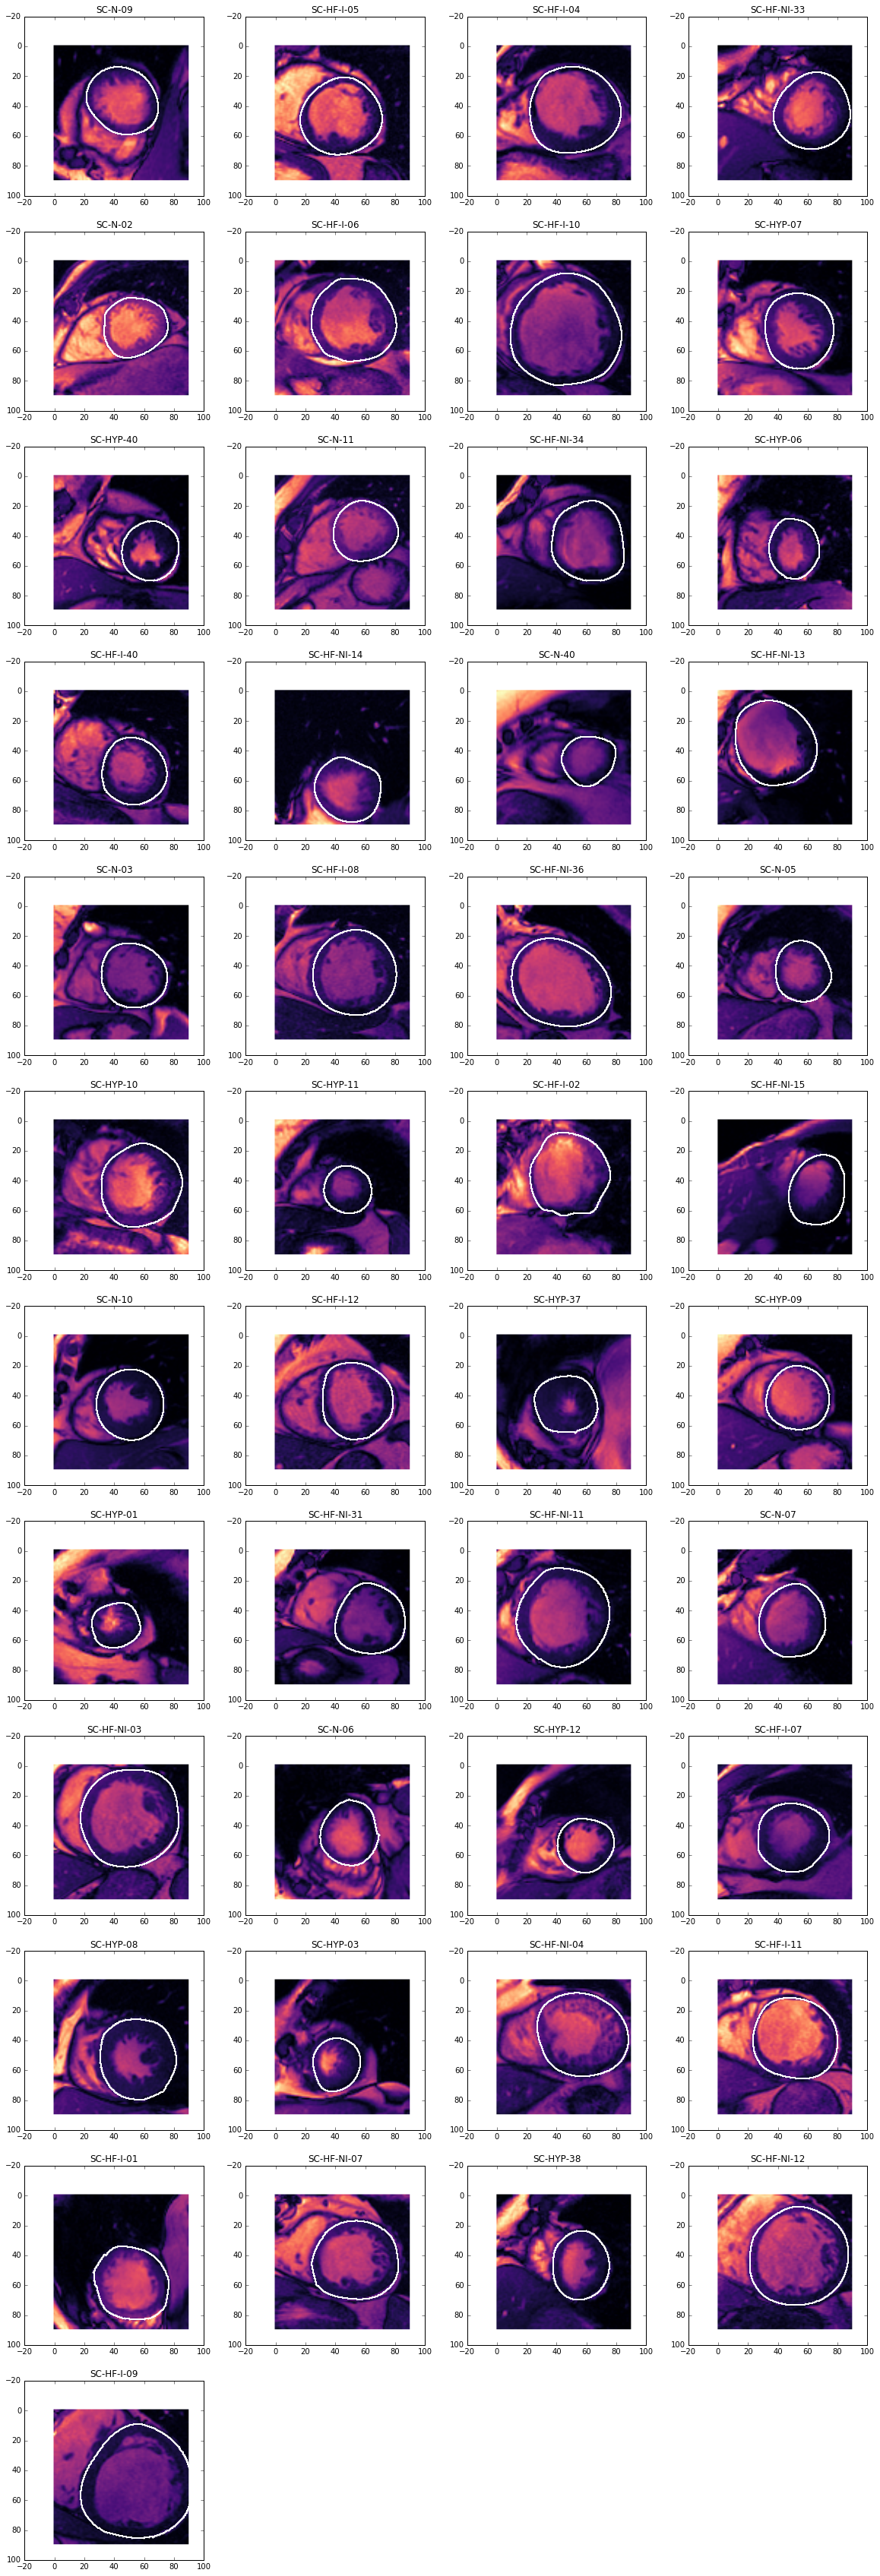

In [10]:
plt.figure(figsize=(20,60))

n = 0
for study_name in sunnybrook_contour_files.keys():
    contour_fname, contour_fpath = sunnybrook_contour_files[study_name]['ocontour'][5]
    contour_coords = get_contour_coords_sunnybrook(contour_fpath)
    try:
        n += 1
        for study_fname, study_fpath in sunnybrook_study_files[study_name]:
            if re.compile('IM-{}-{}'.format(sunnybrook_series_contour_match[study_name], 
                                            contour_fname[8:12])).match(study_fname):
                break
        plt.subplot(12, 4, n)
        plt.title(study_name)
        plt.imshow(dicom.read_file(study_fpath).pixel_array[80:170,80:170], cmap=plt.cm.magma)
        for i in range(len(contour_coords) - 1):
            x0, y0 = contour_coords[i]
            x1, y1 = contour_coords[i+1]
            plt.plot([x0-80, x1-80], [y0-80, y1-80], 'w-', lw=2)
    except:
        print(study_name)

### helper functions

In [11]:
def apply_window(arr, window_center, window_width):
    return np.clip(arr, window_center - window_width/2, window_center + window_width/2)

In [12]:
def apply_per_slice_norm(arr):
    mean = np.mean(arr.ravel())
    std = np.std(arr.ravel())
    if std == 0:
        return np.zeros(arr.shape)
    return (arr - mean) / std

In [13]:
def crop_to_square(arr, size):
    x_len, y_len = arr.shape
    shorter_len = min(x_len, y_len)
    x_start = (arr.shape[0] - shorter_len) // 2
    x_end = x_start + shorter_len
    y_start = (arr.shape[1] - shorter_len) // 2
    y_end = y_start + shorter_len
    return transform.resize(arr[x_start:x_end, y_start:y_end], 
                            (size, size), order=1, clip=True, preserve_range=True)

def crop_to_square_normalized(img_orig, pixel_spacing, size):
    img_norm = ndimage.interpolation.zoom(img_orig, [float(x) for x in pixel_spacing], order=0, mode='constant')
    
    length_x, length_y = img_norm.shape
    if length_x >= size:
        x_start = length_x // 2 - size // 2
        x_end = length_x // 2 + size // 2
    else:
        x_start = 0
        x_end = length_x
    if length_y >= size:
        y_start = length_y // 2 - size // 2
        y_end = length_y // 2 + size // 2
    else:
        y_start = 0
        y_end = length_y
    
    img_new = np.zeros((size, size))
    new_x_shift = (size - (x_end - x_start)) // 2
    new_y_shift = (size - (y_end - y_start)) // 2
    img_new[new_x_shift:(new_x_shift + x_end - x_start), 
            new_y_shift:(new_y_shift + y_end - y_start)] = img_norm[x_start:x_end, y_start:y_end]
    
    return img_new

In [14]:
def create_area_fill(contour_coords, img_shape):
    '''segment_mask = np.zeros(img_shape).astype(np.bool)
    for x, y in contour_coords:
        segment_mask[round(y), round(x)] = True
    segment_mask = ndimage.morphology.binary_fill_holes(segment_mask)'''
    if len(contour_coords) == 0:
        return np.zeros(img_shape).astype(np.bool)
    else:
        p = path.Path(contour_coords)
        nx, ny = img_shape
        y, x = np.meshgrid(np.arange(nx), np.arange(ny))
        x, y = x.flatten(), y.flatten()
        segment_mask = p.contains_points(np.vstack((x,y)).T)
        segment_mask = segment_mask.reshape((ny,nx)).T.astype(np.bool)
        return segment_mask

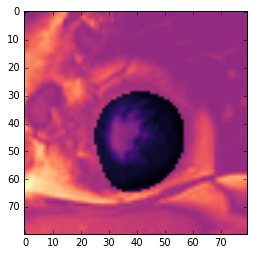

In [25]:
## test area fill function

study_name = 'SC-HYP-03'
contour_fname, contour_fpath = sunnybrook_contour_files[study_name]['ocontour'][5]
contour_coords = get_contour_coords_sunnybrook(contour_fpath)

for study_fname, study_fpath in sunnybrook_study_files[study_name]:
    if re.compile('IM-{}-{}'.format(sunnybrook_series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
        break
img = dicom.read_file(study_fpath).pixel_array
plt.imshow(img[90:170,80:160] - 500 * create_area_fill(contour_coords, img.shape)[90:170, 80:160], cmap=plt.cm.magma)

In [33]:
def split_img2d(img, mask, factor, nb):
    # assumes square shape
    newsize = img.shape[0] // factor
    splits = []
    for i in range(nb):
        rand_y = random.randint(0, img.shape[0] - newsize)
        rand_x = random.randint(0, img.shape[1] - newsize)
        splits.append((img[rand_y:(rand_y+newsize), rand_x:(rand_x+newsize)],
                       mask[rand_y:(rand_y+newsize), rand_x:(rand_x+newsize)]))
    return splits

In [34]:
def img_augmentation(img, mask, nb_samples, rotation=True, shift=True):
    
    img_aug_pairs = []
        
    for i in range(nb_samples):
    
        img_aug = img
        mask_aug = mask
            
        # shift +/- 0 to 0.25
        if shift:
            shift_y = round(0.25 * random.randrange(-img.shape[0], img.shape[0]))
            shift_x = round(0.25 * random.randrange(-img.shape[1], img.shape[1]))
            img_aug, mask_aug = (ndimage.interpolation.shift(img_aug, (shift_y, shift_x), order=0, mode='constant'),
                                 ndimage.interpolation.shift(mask_aug, (shift_y, shift_x), order=0, mode='constant'))
    
        # rotation +/- 0 to 45 degrees with probability 0.5
        if rotation and random.random() > 0.5:
            angle = random.randrange(-45, 45)
            img_aug, mask_aug = (ndimage.interpolation.rotate(img_aug, angle, axes=(0, 1), 
                                                              order=0, mode='constant', reshape=False),
                                 ndimage.interpolation.rotate(mask_aug, angle, axes=(0, 1), 
                                                              order=0, mode='constant', reshape=False))
        
        img_aug_pairs.append((img_aug, mask_aug))
        
    return img_aug_pairs

In [31]:
validation_studies = random.sample(list(sunnybrook_contour_files.keys()), 5)
training_studies = [study for study in list(sunnybrook_contour_files.keys()) if study not in validation_studies]

In [32]:
print('validation:', validation_studies)
print('training:', training_studies)

validation: ['SC-HYP-09', 'SC-HF-NI-12', 'SC-N-03', 'SC-HF-NI-31', 'SC-N-02']
training: ['SC-N-09', 'SC-HF-I-05', 'SC-HF-I-04', 'SC-HF-NI-33', 'SC-HF-I-06', 'SC-HF-I-10', 'SC-HYP-07', 'SC-HYP-40', 'SC-N-11', 'SC-HF-NI-34', 'SC-HYP-06', 'SC-HF-I-40', 'SC-HF-NI-14', 'SC-N-40', 'SC-HF-NI-13', 'SC-HF-I-08', 'SC-HF-NI-36', 'SC-N-05', 'SC-HYP-10', 'SC-HYP-11', 'SC-HF-I-02', 'SC-HF-NI-15', 'SC-N-10', 'SC-HF-I-12', 'SC-HYP-37', 'SC-HYP-01', 'SC-HF-NI-11', 'SC-N-07', 'SC-HF-NI-03', 'SC-N-06', 'SC-HYP-12', 'SC-HF-I-07', 'SC-HYP-08', 'SC-HYP-03', 'SC-HF-NI-04', 'SC-HF-I-11', 'SC-HF-I-01', 'SC-HF-NI-07', 'SC-HYP-38', 'SC-HF-I-09']


In [36]:
data_full_training = []
labels_full_training = []
data_full_validation = []
labels_full_validation = []

full_size = 256

for study_name in tqdm(sunnybrook_contour_files.keys()):
    for contour_fname, contour_fpath in sunnybrook_contour_files[study_name]['ocontour']:
        contour_coords = get_contour_coords_sunnybrook(contour_fpath)
        study_fname, study_fpath = get_matching_dicom_sunnybrook_contours(study_name, contour_fname)
        if study_fpath is None:
            continue
            
        img = dicom.read_file(study_fpath).pixel_array
        segment_mask = create_area_fill(contour_coords, img.shape)
        
        img_processed = crop_to_square(img, full_size)
        segment_mask_processed = crop_to_square(segment_mask, full_size)
        
        for image_aug, mask_aug in img_augmentation(img_processed, segment_mask_processed, 50, rotation=True, shift=True):
            
            image_aug = apply_per_slice_norm(image_aug)
        
            if study_name in training_studies:
                data_full_training.append(np.expand_dims(image_aug, axis=0))
                labels_full_training.append(mask_aug)
            elif study_name in validation_studies:
                data_full_validation.append(np.expand_dims(image_aug, axis=0))
                labels_full_validation.append(mask_aug)
            
data_full_training = np.array(data_full_training).astype(np.float32)
labels_full_training = np.array(labels_full_training).astype(np.bool)
data_full_validation = np.array(data_full_validation).astype(np.float32)
labels_full_validation = np.array(labels_full_validation).astype(np.bool)

print(data_full_training.shape, labels_full_training.shape)
print(data_full_validation.shape, labels_full_validation.shape)

(18450, 1, 256, 256) (18450, 256, 256)
(2550, 1, 256, 256) (2550, 256, 256)


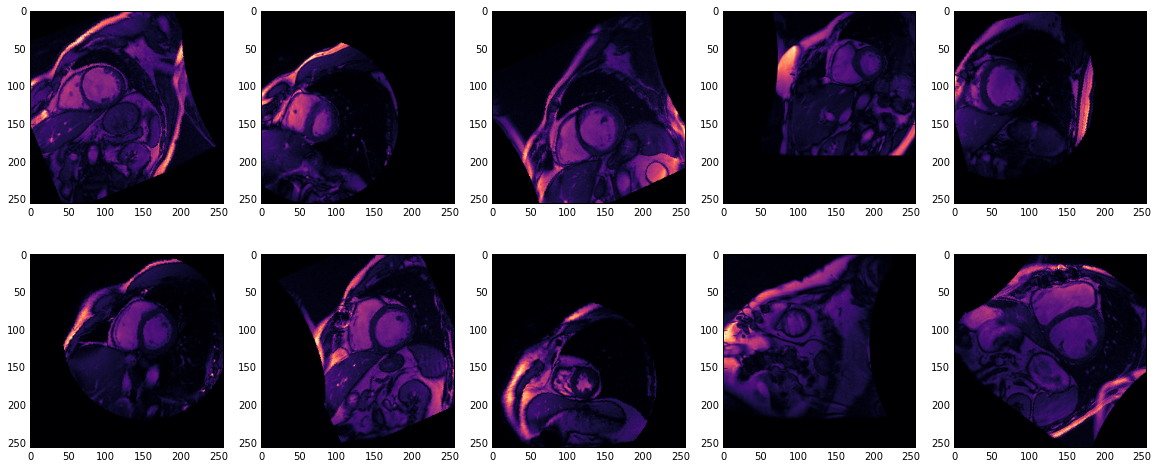

In [37]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(data_full_training[random.randint(0,data_full_training.shape[0]),0,:,:], cmap=plt.cm.magma)

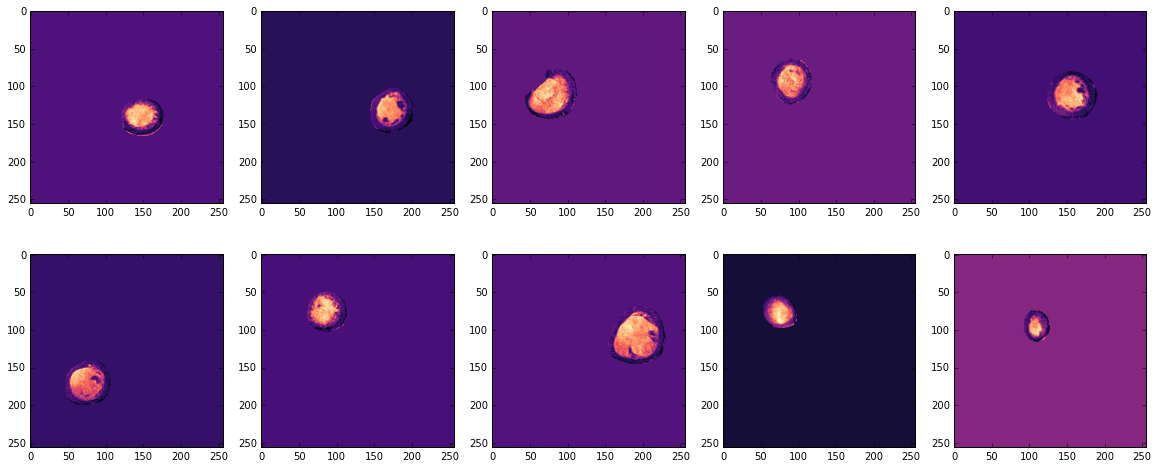

In [38]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    rand_i = random.randint(0,data_full_training.shape[0])
    plt.imshow(data_full_training[rand_i,0,:,:] * \
               labels_full_training[rand_i,:,:], cmap=plt.cm.magma)

In [39]:
shuffle_index = list(range(data_full_training.shape[0]))
random.shuffle(shuffle_index)
data_full_training = data_full_training[shuffle_index]
labels_full_training = labels_full_training[shuffle_index]

shuffle_index = list(range(data_full_validation.shape[0]))
random.shuffle(shuffle_index)
data_full_validation = data_full_validation[shuffle_index]
labels_full_validation = labels_full_validation[shuffle_index]

In [40]:
joblib.dump((validation_studies, training_studies,
             data_full_training, labels_full_training,
             data_full_validation, labels_full_validation), 
            '../../data_proc/sunnybrook_ocontour_segmentation_training.pkl')

['../../data_proc/sunnybrook_ocontour_segmentation_training.pkl',
 '../../data_proc/sunnybrook_ocontour_segmentation_training.pkl_01.npy',
 '../../data_proc/sunnybrook_ocontour_segmentation_training.pkl_02.npy',
 '../../data_proc/sunnybrook_ocontour_segmentation_training.pkl_03.npy',
 '../../data_proc/sunnybrook_ocontour_segmentation_training.pkl_04.npy']

### training

In [41]:
from keras.models import Sequential, Graph
from keras.layers.core import Activation, Dense, Dropout, Flatten, Merge, Reshape, Lambda
from keras.layers.core import TimeDistributedDense, TimeDistributedMerge
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ParametricSoftplus, ELU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise
from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

# for preventing python max recursion limit error
import sys
sys.setrecursionlimit(50000)

Using Theano backend.


Using gpu device 3: Tesla K80 (CNMeM is disabled)


In [16]:
(validation_studies, training_studies,
 data_full_training, labels_full_training,
 data_full_validation, labels_full_validation) = joblib.load('../../data_proc/sunnybrook_ocontour_segmentation_training.pkl')

In [42]:
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=None, keepdims=False))

def binaryCE(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=None, keepdims=False)

In [43]:
from keras import initializations
from keras.layers.core import Layer
from keras import backend as K


class Rotate90(Layer):
    def __init__(self, direction='clockwise', **kwargs):
        super(Rotate90, self).__init__(**kwargs)
        self.direction = direction

    def get_output(self, train):
        X = self.get_input(train)
        if self.direction == 'clockwise':
            return X.transpose((0, 2, 1))[:, :, ::-1]
        elif self.direction == 'counterclockwise':
            return X.transpose((0, 2, 1))[:, ::-1, :]
        else:
            raise

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Rotate90, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [44]:
# adapted from @the-moliver https://github.com/fchollet/keras/pull/1470

from keras.layers.core import Layer
from keras import initializations
from keras import backend as K

class BatchNormalization(Layer):
    '''Normalize the activations of the previous layer at each batch,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # Arguments
        epsilon: small float > 0. Fuzz parameter.
        mode: integer, 0 or 1.
            - 0: feature-wise normalization.
                If the input has multiple feature dimensions,
                each will be normalized separately
                (e.g. for an image input with shape
                `(channels, rows, cols)`,
                each combination of a channel, row and column
                will be normalized separately).
            - 1: sample-wise normalization. This mode assumes a 2D input.
            - 2: standard implementation feature-wise normalization on a per batch basis.
                The running average is only used to compute the prediction.
                If the input has multiple feature dimensions,
                each will be normalized separately
                (e.g. for an image input with shape
                `(channels, rows, cols)`,
                each combination of a channel, row and column
                will be normalized separately).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
    # References
        - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](http://arxiv.org/pdf/1502.03167v3.pdf)
    '''
    def __init__(self, epsilon=1e-6, mode=2, momentum=0.1,
                 weights=None, **kwargs):
        self.init = initializations.get("uniform")
        self.epsilon = epsilon
        self.mode = mode
        self.momentum = momentum
        self.initial_weights = weights
        super(BatchNormalization, self).__init__(**kwargs)

    def build(self):
        input_shape = self.input_shape  # starts with samples axis
        input_shape = input_shape[1:]

        self.gamma = self.init(input_shape)
        self.beta = K.zeros(input_shape)

        self.params = [self.gamma, self.beta]
        self.running_mean = K.zeros(input_shape)
        self.running_std = K.ones(input_shape)

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def get_weights(self):
        super_weights = super(BatchNormalization, self).get_weights()
        return super_weights + [K.get_value(self.running_mean),
                                K.get_value(self.running_std)]

    def set_weights(self, weights):
        K.set_value(self.running_mean, weights[-2])
        K.set_value(self.running_std, weights[-1])
        super(BatchNormalization, self).set_weights(weights[:-2])

    def get_output(self, train):
        X = self.get_input(train)
        if self.mode == 0:
            m = K.mean(X, axis=0)
            std = K.mean(K.square(X - m) + self.epsilon, axis=0)
            std = K.sqrt(std)
            mean_update = self.momentum * self.running_mean + (1-self.momentum) * m
            std_update = self.momentum * self.running_std + (1-self.momentum) * std
            self.updates = [(self.running_mean, mean_update),
                            (self.running_std, std_update)]
            X_normed = ((X - self.running_mean) /
                        (self.running_std + self.epsilon))
        elif self.mode == 1:
            m = K.mean(X, axis=-1, keepdims=True)
            std = K.std(X, axis=-1, keepdims=True)
            X_normed = (X - m) / (std + self.epsilon)
        elif self.mode == 2:
            if train:
                m = K.mean(X, axis=0)
                std = K.mean(K.square(X - m) + self.epsilon, axis=0)
                std = K.sqrt(std)
                mean_update = self.momentum * self.running_mean + (1-self.momentum) * m
                std_update = self.momentum * self.running_std + (1-self.momentum) * std
                self.updates = [(self.running_mean, mean_update),
                                (self.running_std, std_update)]
                X_normed = ((X - m) /
                            (std + self.epsilon))
            else:
                X_normed = ((X - self.running_mean) /
                            (self.running_std + self.epsilon))
        out = self.gamma * X_normed + self.beta
        return out

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "epsilon": self.epsilon,
                  "mode": self.mode,
                  "momentum": self.momentum}
        base_config = super(BatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [45]:
model = Graph()

model.add_input(name='input', input_shape=(1, 256, 256))

model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-1', input='input')
model.add_node(BatchNormalization(), name='conv-1-1-bn', input='conv-1-1')
model.add_node(ELU(), name='conv-1-1-activ', input='conv-1-1-bn')
model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-2', input='conv-1-1-activ')
model.add_node(BatchNormalization(), name='conv-1-2-bn', input='conv-1-2')
model.add_node(ELU(), name='conv-1-2-activ', input='conv-1-2-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-1', input='conv-1-2-activ')

model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-1', input='pool-1')
model.add_node(BatchNormalization(), name='conv-2-1-bn', input='conv-2-1')
model.add_node(ELU(), name='conv-2-1-activ', input='conv-2-1-bn')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-2', input='conv-2-1-activ')
model.add_node(BatchNormalization(), name='conv-2-2-bn', input='conv-2-2')
model.add_node(ELU(), name='conv-2-2-activ', input='conv-2-2-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-2', input='conv-2-2-activ')

model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-1', input='pool-2')
model.add_node(BatchNormalization(), name='conv-3-1-bn', input='conv-3-1')
model.add_node(ELU(), name='conv-3-1-activ', input='conv-3-1-bn')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-2', input='conv-3-1-activ')
model.add_node(BatchNormalization(), name='conv-3-2-bn', input='conv-3-2')
model.add_node(ELU(), name='conv-3-2-activ', input='conv-3-2-bn')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-3', input='conv-3-2-activ')
model.add_node(BatchNormalization(), name='conv-3-3-bn', input='conv-3-3')
model.add_node(ELU(), name='conv-3-3-activ', input='conv-3-3-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-3', input='conv-3-3-activ')

model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-1', input='pool-3')
model.add_node(BatchNormalization(), name='conv-4-1-bn', input='conv-4-1')
model.add_node(ELU(), name='conv-4-1-activ', input='conv-4-1-bn')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-2', input='conv-4-1-activ')
model.add_node(BatchNormalization(), name='conv-4-2-bn', input='conv-4-2')
model.add_node(ELU(), name='conv-4-2-activ', input='conv-4-2-bn')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-3', input='conv-4-2-activ')
model.add_node(BatchNormalization(), name='conv-4-3-bn', input='conv-4-3')
model.add_node(ELU(), name='conv-4-3-activ', input='conv-4-3-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-4', input='conv-4-3-activ')

model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-1', input='pool-4')
model.add_node(BatchNormalization(), name='conv-5-1-bn', input='conv-5-1')
model.add_node(ELU(), name='conv-5-1-activ', input='conv-5-1-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-2', input='conv-5-1-activ')
model.add_node(BatchNormalization(), name='conv-5-2-bn', input='conv-5-2')
model.add_node(ELU(), name='conv-5-2-activ', input='conv-5-2-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-3', input='conv-5-2-activ')
model.add_node(BatchNormalization(), name='conv-5-3-bn', input='conv-5-3')
model.add_node(ELU(), name='conv-5-3-activ', input='conv-5-3-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-5', input='conv-5-3-activ')

model.add_node(Flatten(), name='flatten', input='pool-5')
model.add_node(Dense(4096, activation='relu'), name='fc-1', input='flatten')
model.add_node(Dropout(0.5), name='dropout-1', input='fc-1')
model.add_node(Dense(4096, activation='relu'), name='fc-2', input='dropout-1')
model.add_node(Dropout(0.5), name='dropout-2', input='fc-2')
model.add_node(Reshape((64, 8, 8)), name='reshape', input='dropout-2')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-1', input='reshape')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-1', input='unpool-1')
model.add_node(BatchNormalization(), name='deconv-1-1-bn', input='deconv-1-1')
model.add_node(ELU(), name='deconv-1-1-activ', input='deconv-1-1-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-2', input='deconv-1-1-activ')
model.add_node(BatchNormalization(), name='deconv-1-2-bn', input='deconv-1-2')
model.add_node(ELU(), name='deconv-1-2-activ', input='deconv-1-2-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-3', input='deconv-1-2-activ')
model.add_node(BatchNormalization(), name='deconv-1-3-bn', input='deconv-1-3')
model.add_node(ELU(), name='deconv-1-3-activ', input='deconv-1-3-bn')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-2', input='deconv-1-3-activ')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-1', input='unpool-2')
model.add_node(BatchNormalization(), name='deconv-2-1-bn', input='deconv-2-1')
model.add_node(ELU(), name='deconv-2-1-activ', input='deconv-2-1-bn')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-2', input='deconv-2-1-activ')
model.add_node(BatchNormalization(), name='deconv-2-2-bn', input='deconv-2-2')
model.add_node(ELU(), name='deconv-2-2-activ', input='deconv-2-2-bn')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-3', input='deconv-2-2-activ')
model.add_node(BatchNormalization(), name='deconv-2-3-bn', input='deconv-2-3')
model.add_node(ELU(), name='deconv-2-3-activ', input='deconv-2-3-bn')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-3', input='deconv-2-3-activ')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-1', input='unpool-3')
model.add_node(BatchNormalization(), name='deconv-3-1-bn', input='deconv-3-1')
model.add_node(ELU(), name='deconv-3-1-activ', input='deconv-3-1-bn')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-2', input='deconv-3-1-activ')
model.add_node(BatchNormalization(), name='deconv-3-2-bn', input='deconv-3-2')
model.add_node(ELU(), name='deconv-3-2-activ', input='deconv-3-2-bn')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-3', input='deconv-3-2-activ')
model.add_node(BatchNormalization(), name='deconv-3-3-bn', input='deconv-3-3')
model.add_node(ELU(), name='deconv-3-3-activ', input='deconv-3-3-bn')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-4', input='deconv-3-3-activ')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-1', input='unpool-4')
model.add_node(BatchNormalization(), name='deconv-4-1-bn', input='deconv-4-1')
model.add_node(ELU(), name='deconv-4-1-activ', input='deconv-4-1-bn')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-2', input='deconv-4-1-activ')
model.add_node(BatchNormalization(), name='deconv-4-2-bn', input='deconv-4-2')
model.add_node(ELU(), name='deconv-4-2-activ', input='deconv-4-2-bn')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-5', input='deconv-4-2-activ')
model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-1', input='unpool-5')
model.add_node(BatchNormalization(), name='deconv-5-1-bn', input='deconv-5-1')
model.add_node(ELU(), name='deconv-5-1-activ', input='deconv-5-1-bn')
model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-2', input='deconv-5-1-activ')
model.add_node(BatchNormalization(), name='deconv-5-2-bn', input='deconv-5-2')
model.add_node(ELU(), name='deconv-5-2-activ', input='deconv-5-2-bn')

model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='prob-map', input='deconv-5-2-activ')
model.add_node(Reshape((256, 256)), name='prob-map-reshape', input='prob-map')
model.add_node(Dropout(0.5), name='prob-map-dropout', input='prob-map-reshape')

model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we', input='prob-map-dropout')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew', input='prob-map-dropout')
model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-1', inputs=['rnn-we', 'rnn-ew'], merge_mode='concat', concat_axis=-1)

model.add_node(Rotate90(direction='counterclockwise'), name='rotate', input='prob-map-dropout')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns', input='rotate')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn', input='rotate')
model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-2-rotated', inputs=['rnn-ns', 'rnn-sn'], merge_mode='concat', concat_axis=-1)
model.add_node(Rotate90(direction='clockwise'), name='rnn-2', input='rnn-2-rotated')

model.add_node(Activation('linear'), name='pre-output', inputs=['rnn-1', 'rnn-2'], merge_mode='ave')
model.add_output(name='output', input='pre-output')

model.compile('adam', {'output': binaryCE})

In [ ]:
batch_size = 32
nb_epoch = 100

checkpointer = ModelCheckpoint(filepath='../../model_weights/sunnybrook_ocontour_segmentation.hdf5',
                               verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

model.fit({'input': data_full_training, 'output': labels_full_training},
          batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, shuffle=True,
          validation_data={'input': data_full_validation, 'output': labels_full_validation},
          callbacks=[checkpointer, earlystopping])

The above training code is run separately in a script.

### test segmentation

In [21]:
model.load_weights('../../model_weights/sunnybrook_ocontour_segmentation.hdf5')

In [ ]:
i = 18
img = data_full_validation[i,0,:,:]
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(2,2,2)
plt.imshow(labels_full_validation[i,:,:], cmap=plt.cm.hot)

segmentation = model.predict({'input': np.expand_dims(np.expand_dims(img, axis=0), axis=0)}, 
                             verbose=0)['output'][0,:,:]


plt.subplot(2,2,3)
plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(2,2,4)
plt.imshow(img * segmentation, cmap=plt.cm.magma)

In [ ]:
study_name = 'SC-HF-NI-04'
contour_fname, contour_fpath = contour_files[study_name]['icontour'][0]
for study_fname, study_fpath in study_files[study_name]:
    if re.compile('IM-{}-{}'.format(series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
        break
img = apply_per_slice_norm(crop_to_square(dicom.read_file(study_fpath).pixel_array, 256))
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(1,3,2)

segmentation = model.predict({'input': np.expand_dims(np.expand_dims(img, axis=0), axis=0)}, 
                             verbose=0)['output'][0,:,:]

plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(1,3,3)
plt.imshow(img * segmentation, cmap=plt.cm.magma)

In [ ]:
img = dicom.read_file('/home/leon/ML/kaggle/dsb/data/train/97/study/sax_10/IM-10982-0030.dcm').pixel_array
img = apply_per_slice_norm(crop_to_square(img, 256))

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(1,3,2)

segmentation = model.predict({'input': np.expand_dims(np.expand_dims(img, axis=0), axis=0)}, 
                             verbose=0)['output'][0,:,:]

plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(1,3,3)
plt.imshow(img * segmentation, cmap=plt.cm.magma)